## Neural Network Framework Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipdb
from scipy.special import expit

In [251]:
class Layer:

    #Activation Functions
    def tanh(self, x):
        return np.tanh(x)
    def d_tanh(self, x):
        return 1 - np.square(np.tanh(x))
    def sigmoid(self, x):
        return expit(x)
    def d_sigmoid(self, x):
        return (1 - self.sigmoid(x)) * self.sigmoid(x)
    def ReLu(self, z):
        return np.maximum(0, z)
    def d_ReLu(self, Z):
        return Z > 0
    
    #For output layer, useful for multiclass classification
    def softmax(self, Z):
        return np.exp(Z) / sum(np.exp(Z))
    def d_softmax(self, Z):
        pass
    
    activationFunctions = {
        'tanh': (tanh, d_tanh),
        'sigmoid': (sigmoid, d_sigmoid),
        'reLu': (ReLu, d_ReLu),
        'softmax': (softmax, d_softmax)
    }
    
    #Input -> num of neurons in prev layer, Neurons --> num neurons in cur layer, Activation -> activation fxn to use
    def __init__(self, inputs, neurons, activation):
        self.neurons = neurons
        self.W = np.random.rand(neurons, inputs) - 0.5
        self.b = np.random.rand(neurons, 1) - 0.5
        self.Z = None
        self.A_prev = None
        self.act, self.d_act = self.activationFunctions.get(activation)
        
    def initializeWeights(self, inputs, neurons):
        self.W = np.random.rand(neurons, inputs) - 0.5
        
    def getNeuronCount(self):
        return self.neurons
    
    def getWeights(self):
        return self.W
    
    def getBias(self):
        return self.b
    
    def setWeight(self, weight):
        self.W = weight
        
    def setBias(self, bias):
        self.b = bias
        
    def feedForward(self, A_prev):
        #ipdb.set_trace()
        self.A_prev = A_prev
        self.Z = self.W.dot(self.A_prev) + self.b
        self.A = self.act(self, self.Z)
        return self.A
    
    #All derivatives are wrt to cost
    #Expects dA of cur layer
    #Special case where doing multi class classification with mutli class logloss, you can get the dZ wrt dC directly without having to first get dA
    def backprop(self, dA, learning_rate, dZ_Special):
        
        #ipdb.set_trace()
        
        #elementt by element matrix multip, not a normal dot prod since both matrices have same shape (essentialyl scalar)
        dZ = np.multiply(self.d_act(self, self.Z), dA) if dZ_Special.any() == None else dZ_Special
        
         # need to normalize weights and divide by number of samples
        # because it is actually a sum of weights
        dW = 1/dZ.shape[1] * np.dot(dZ, self.A_prev.T)
        
        # this is to match shape since biases is supposed to be a col vector with 1 col but dZ has m cols
        # w/ m being num of samples, we want to take avg of all samples in dZ (i.e on a row by row basis, sum of cols
        # and divide by total num of smamples)
        db = 1 / dZ.shape[1] * np.sum(dZ, axis = 1, keepdims = True)
        
        dA_prev = np.dot(self.W.T, dZ)
        
        self.W = self.W - learning_rate * dW
        self.b = self.b - learning_rate * db
        return dA_prev
    

In [266]:
class NeuralNet:
    
    #Loss Functions, mse for regression, logloss for classification
    def mse(self, a, target):
        return np.square(a-target)
    
    def d_mse(self, a, target):
        return 2*(a-target)
    
    def binary_logloss(self, a, target):
        return -(target*np.log(a) + (1-target)*np.log(1-a))
    
    def d_binary_logloss(self, a, target):
        return (a - target)/(a*(1 - a))
    
    #Source - https://www.kaggle.com/c/predict-closed-questions-on-stack-overflow/discussion/2644
    def multi_logloss(self, a, target, eps=1e-15):
        predictions = np.clip(a, eps, 1 - eps)

        # normalize row sums to 1
        predictions /= predictions.sum(axis=1)[:, np.newaxis]

        return -np.sum(target * np.log(predictions))/predictions.shape[0]
    
    def d_multi_logloss(self, a, target):
        return np.zeros(a.shape) # kinda just a placeholder
    
    lossFunctions = {
        'mse': (mse, d_mse),
        'binary_logloss': (binary_logloss, d_binary_logloss),
        'multi_logloss': (multi_logloss, d_multi_logloss)
    }
        
    #LossFunction is either mse of logloss
    def __init__(self, lossFunction):
        self.layers = []
        self.learning_rate = 0.1
        self.epochs = 100
        self.batch_size = 10
        self.classification = False if lossFunction == 'mse' else True
        self.lossFunction = lossFunction
        self.loss, self.d_loss = self.lossFunctions.get(lossFunction)
    
    #Units is 1-n and activationFunction is 'ReLu', 'sigmoid', 'tanh', or 'softmax'
    def addLayer(self, units, activationFunction):
        prevLayerNeuronCount = self.layers[-1].getNeuronCount() if len(self.layers) > 0 else 0
        self.layers.append(Layer(prevLayerNeuronCount, units, activationFunction))
        
    def getNumBatches(self, num_samples, batch_size):
        if (num_samples == batch_size):
            return 1
        elif (num_samples > batch_size):
            if (num_samples % batch_size == 0):
                return num_samples // batch_size
            else:
                return (num_samples // batch_size) + 1
        else:
            return 1
        
    def oneHot(self, x):
        one_hot_X = np.zeros((x.max() + 1, x.size)) #making a matrix of 10 x m
        one_hot_X[x, np.arange(x.size)] = 1 #going through all cols and setting the row w/ index corresponding to the y to 1, its very easy to iterate over numpy arays like this apparently
        return one_hot_X
    
    #Convert one hot encoded 2d array to original array of 1d
    def rev_one_hot(self, target):
        rev_one_hot = np.argmax(target, 0)
        return rev_one_hot
    #Compare two 1d arrays
    def get_accuracy(self, target, Y, accuracy_buffer):
        #ipdb.set_trace()
        return np.sum(abs(target-Y)<accuracy_buffer) / Y.size
    
    def get_layer_biases(self):
        biases = []
        for layer in self.layers:
            biases.append(layer.getBias())
        return biases
    
    def get_layer_weights(self):
        weights = []
        for layer in self.layers:
            weights.append(layer.getWeights())
        return weights

    # Pass weights array, num of elemtns in weights array has to match up w/ layers and num of neurons in layers
    def set_weights(self, weights):
        if (len(weights) != len(self.layers)):
            raise ValueError("Num of layers and num of weihts must match")
        for count, weight in enumerate(weights):
                if (weight.shape[0] != self.layers[count].getNeuronCount()):
                    raise ValueError("Num of rows in weights at index " + count + " does not match num of neurons in layer " + count)
        for count, weight in enumerate(weights):
            self.layers[count].setWeight(weight)
            
    def set_biases(self, biases):
        if (len(biases) != len(self.layers)):
            raise ValueError("Num of layers and num of biases must match")
        for count, bias in enumerate(biases):
            if (bias.shape[0] != self.layers[count].getNeuronCount()):
                raise ValueError("Num of rows in biases at index " + count + " does not match num of neurons in layer " + count)
        for count, bias in enumerate(biases):
            self.layers[count].setBias(bias)
        
        
    def fit(self, X, y, epochs = None, batch_size = None, learning_rate = None, accuracy_buffer = 0.1):
        self.learning_rate = learning_rate if learning_rate != None else self.learning_rate
        self.epochs = epochs if epochs != None else self.epochs
        self.batch_size = batch_size if batch_size != None else self.batch_size
        
        #Need at min one layer
        if (len(self.layers) == 0):
            raise ValueError('No layers have been added. Need at least one layer. Please add a layer') 
        
        #multi class classificaiton problem need y to be one hot encoded and must use multi log loss
        multiClassProblem = self.classification and (y.max() - y.min() > 1)
        if (multiClassProblem):
            y = self.oneHot(y)
            if (self.lossFunction != 'multi_logloss'):
                raise ValueError('Loss Function Must be multi_logloss for multi class classification')
        
        epoch_costs = []
        batches_cost_sum = 0
        num_batches = self.getNumBatches(X.shape[1], self.batch_size)
        
        #Initializing weights of the first layer 
        #Need to do it right now because shape of input isnt known until now
        self.layers[0].initializeWeights(X.shape[0], self.layers[0].getNeuronCount())
        
        ###-----Epoch iterations, training occurs here-----###
        for epoch in range(self.epochs):
            batches_cost_sum = 0
            for batch in range(num_batches):
                
                ###-----Obtaining appropriate batch data-----###
                A = X[:, batch*self.batch_size:(batch+1)*self.batch_size]
                
                if (multiClassProblem): 
                    y_curBatch = y[:, batch*self.batch_size:(batch+1)*self.batch_size]
                else:
                    y_curBatch = y[batch*self.batch_size:(batch+1)*self.batch_size]
            
                ###-----Performing forward prop and backprop-----###
                #ipdb.set_trace()
                for layer in self.layers:
                    A = layer.feedForward(A)
                batches_cost_sum += 1/self.batch_size * np.sum(self.loss(self, A, y_curBatch))
                
                #For multi class classiifcaiton problems (class > 2) and using softmax, deriv of softmax w.r.t to Zfinal is just actual - pred
                dZ_Special = A - y_curBatch if multiClassProblem else np.array([None])
                
                #After the final output layer dA is found like this since A is just the output
                dA = self.d_loss(self, A, y_curBatch)
                
                #Only final layer does the special dZ matter and only if multi class
                for layer in reversed(self.layers):
                    if (layer == self.layers[-1]):
                        dA = layer.backprop(dA, self.learning_rate, dZ_Special)
                    else:
                        dA = layer.backprop(dA, self.learning_rate, np.array([None]))
                
                ###-----Logging Metrics-----###
                if (epoch % 10 == 0 and batch == num_batches-1):
                    print("-----Epoch: ", epoch, "-----")
                    if (multiClassProblem):
                        A = self.rev_one_hot(A)
                        y_curBatch = self.rev_one_hot(y_curBatch)
                    print("Accuracy:", self.get_accuracy(A, y_curBatch, accuracy_buffer))
                    print("Cost:", batches_cost_sum)
            epoch_costs.append(batches_cost_sum) 
        return epoch_costs, self.get_layer_weights(), self.get_layer_biases()
        
    def predict(self, X):
        A = X
        for layer in self.layers:
            A = layer.feedForward(A)
        return A
    

## Neural Net Uses

Below are three exampels of the neural net in use. In the first example, the net is trained to learn the XOR function. In the second example, the neural net learns the relationshp between petal length and flower height in the flower problem using a general perceptron. In the final example, the MNIST data set is trainedi in various ways to achieve differing levels of accuracy.

### XOR Function

In [4]:
x_train = np.array([[0, 0, 1, 1], 
                    [0, 1, 0, 1]]) # 2 inputs and 4 samples, i.e 2x4
y_train = np.array([0, 1, 1, 0]) #1 x num of samples
Xor_net = NeuralNet('binary_logloss')
Xor_net.addLayer(3, 'tanh')
Xor_net.addLayer(1, 'sigmoid')
costs, weights = Xor_net.fit(x_train, y_train, 10000)

-----Epoch:  0 -----
Accuracy: 0.0
Cost: 0.28575244552498663
-----Epoch:  10 -----
Accuracy: 0.0
Cost: 0.2807814346582089
-----Epoch:  20 -----
Accuracy: 0.0
Cost: 0.27860517211026387
-----Epoch:  30 -----
Accuracy: 0.0
Cost: 0.2775317716957579
-----Epoch:  40 -----
Accuracy: 0.0
Cost: 0.27690237039374804
-----Epoch:  50 -----
Accuracy: 0.0
Cost: 0.27645377566283136
-----Epoch:  60 -----
Accuracy: 0.0
Cost: 0.2760781753347831
-----Epoch:  70 -----
Accuracy: 0.0
Cost: 0.27572966248007835
-----Epoch:  80 -----
Accuracy: 0.0
Cost: 0.275387191812383
-----Epoch:  90 -----
Accuracy: 0.0
Cost: 0.2750397415046734
-----Epoch:  100 -----
Accuracy: 0.0
Cost: 0.2746803241295198
-----Epoch:  110 -----
Accuracy: 0.0
Cost: 0.2743035465042742
-----Epoch:  120 -----
Accuracy: 0.0
Cost: 0.2739045977201329
-----Epoch:  130 -----
Accuracy: 0.0
Cost: 0.2734788144191219
-----Epoch:  140 -----
Accuracy: 0.0
Cost: 0.27302148229400475
-----Epoch:  150 -----
Accuracy: 0.0
Cost: 0.2725277379498445
-----Epoch:  1

-----Epoch:  1450 -----
Accuracy: 0.5
Cost: 0.14782468855668382
-----Epoch:  1460 -----
Accuracy: 0.5
Cost: 0.14771159206141143
-----Epoch:  1470 -----
Accuracy: 0.5
Cost: 0.1476007952373863
-----Epoch:  1480 -----
Accuracy: 0.5
Cost: 0.14749222658259867
-----Epoch:  1490 -----
Accuracy: 0.5
Cost: 0.14738581710222487
-----Epoch:  1500 -----
Accuracy: 0.5
Cost: 0.14728150018926517
-----Epoch:  1510 -----
Accuracy: 0.5
Cost: 0.14717921151054547
-----Epoch:  1520 -----
Accuracy: 0.5
Cost: 0.14707888889773968
-----Epoch:  1530 -----
Accuracy: 0.5
Cost: 0.14698047224308397
-----Epoch:  1540 -----
Accuracy: 0.5
Cost: 0.14688390339947005
-----Epoch:  1550 -----
Accuracy: 0.5
Cost: 0.1467891260846154
-----Epoch:  1560 -----
Accuracy: 0.5
Cost: 0.14669608578902146
-----Epoch:  1570 -----
Accuracy: 0.5
Cost: 0.14660472968744057
-----Epoch:  1580 -----
Accuracy: 0.5
Cost: 0.14651500655357988
-----Epoch:  1590 -----
Accuracy: 0.5
Cost: 0.1464268666777805
-----Epoch:  1600 -----
Accuracy: 0.5
Cost:

-----Epoch:  2990 -----
Accuracy: 1.0
Cost: 0.01403466965096257
-----Epoch:  3000 -----
Accuracy: 1.0
Cost: 0.01383662085404096
-----Epoch:  3010 -----
Accuracy: 1.0
Cost: 0.013644307963821031
-----Epoch:  3020 -----
Accuracy: 1.0
Cost: 0.013457474388195148
-----Epoch:  3030 -----
Accuracy: 1.0
Cost: 0.013275879164955038
-----Epoch:  3040 -----
Accuracy: 1.0
Cost: 0.01309929576462453
-----Epoch:  3050 -----
Accuracy: 1.0
Cost: 0.012927511002215036
-----Epoch:  3060 -----
Accuracy: 1.0
Cost: 0.012760324046608543
-----Epoch:  3070 -----
Accuracy: 1.0
Cost: 0.012597545517569326
-----Epoch:  3080 -----
Accuracy: 1.0
Cost: 0.012438996661520214
-----Epoch:  3090 -----
Accuracy: 1.0
Cost: 0.012284508598213742
-----Epoch:  3100 -----
Accuracy: 1.0
Cost: 0.012133921631302922
-----Epoch:  3110 -----
Accuracy: 1.0
Cost: 0.011987084616584785
-----Epoch:  3120 -----
Accuracy: 1.0
Cost: 0.011843854382365487
-----Epoch:  3130 -----
Accuracy: 1.0
Cost: 0.011704095196993265
-----Epoch:  3140 -----
Accu

-----Epoch:  4420 -----
Accuracy: 1.0
Cost: 0.004672236057332791
-----Epoch:  4430 -----
Accuracy: 1.0
Cost: 0.0046506203282476715
-----Epoch:  4440 -----
Accuracy: 1.0
Cost: 0.004629203517983009
-----Epoch:  4450 -----
Accuracy: 1.0
Cost: 0.004607982889732336
-----Epoch:  4460 -----
Accuracy: 1.0
Cost: 0.00458695575678963
-----Epoch:  4470 -----
Accuracy: 1.0
Cost: 0.004566119481404551
-----Epoch:  4480 -----
Accuracy: 1.0
Cost: 0.004545471473668728
-----Epoch:  4490 -----
Accuracy: 1.0
Cost: 0.004525009190432603
-----Epoch:  4500 -----
Accuracy: 1.0
Cost: 0.004504730134251647
-----Epoch:  4510 -----
Accuracy: 1.0
Cost: 0.00448463185236106
-----Epoch:  4520 -----
Accuracy: 1.0
Cost: 0.004464711935677901
-----Epoch:  4530 -----
Accuracy: 1.0
Cost: 0.00444496801783027
-----Epoch:  4540 -----
Accuracy: 1.0
Cost: 0.004425397774211965
-----Epoch:  4550 -----
Accuracy: 1.0
Cost: 0.004405998921062457
-----Epoch:  4560 -----
Accuracy: 1.0
Cost: 0.004386769214571271
-----Epoch:  4570 -----
Acc

-----Epoch:  5970 -----
Accuracy: 1.0
Cost: 0.002714807391279102
-----Epoch:  5980 -----
Accuracy: 1.0
Cost: 0.002707483215867379
-----Epoch:  5990 -----
Accuracy: 1.0
Cost: 0.0027001983832810592
-----Epoch:  6000 -----
Accuracy: 1.0
Cost: 0.002692952577565023
-----Epoch:  6010 -----
Accuracy: 1.0
Cost: 0.0026857454861380775
-----Epoch:  6020 -----
Accuracy: 1.0
Cost: 0.0026785767997482505
-----Epoch:  6030 -----
Accuracy: 1.0
Cost: 0.0026714462124283194
-----Epoch:  6040 -----
Accuracy: 1.0
Cost: 0.002664353421452582
-----Epoch:  6050 -----
Accuracy: 1.0
Cost: 0.002657298127293737
-----Epoch:  6060 -----
Accuracy: 1.0
Cost: 0.002650280033581044
-----Epoch:  6070 -----
Accuracy: 1.0
Cost: 0.002643298847058535
-----Epoch:  6080 -----
Accuracy: 1.0
Cost: 0.002636354277544395
-----Epoch:  6090 -----
Accuracy: 1.0
Cost: 0.0026294460378907597
-----Epoch:  6100 -----
Accuracy: 1.0
Cost: 0.0026225738439440717
-----Epoch:  6110 -----
Accuracy: 1.0
Cost: 0.0026157374145060995
-----Epoch:  6120 

-----Epoch:  7590 -----
Accuracy: 1.0
Cost: 0.001887211542449652
-----Epoch:  7600 -----
Accuracy: 1.0
Cost: 0.0018836648974647815
-----Epoch:  7610 -----
Accuracy: 1.0
Cost: 0.0018801315368517178
-----Epoch:  7620 -----
Accuracy: 1.0
Cost: 0.0018766113861723337
-----Epoch:  7630 -----
Accuracy: 1.0
Cost: 0.0018731043715433115
-----Epoch:  7640 -----
Accuracy: 1.0
Cost: 0.0018696104196311014
-----Epoch:  7650 -----
Accuracy: 1.0
Cost: 0.0018661294576468156
-----Epoch:  7660 -----
Accuracy: 1.0
Cost: 0.0018626614133410873
-----Epoch:  7670 -----
Accuracy: 1.0
Cost: 0.001859206214999189
-----Epoch:  7680 -----
Accuracy: 1.0
Cost: 0.0018557637914359628
-----Epoch:  7690 -----
Accuracy: 1.0
Cost: 0.0018523340719911277
-----Epoch:  7700 -----
Accuracy: 1.0
Cost: 0.0018489169865242895
-----Epoch:  7710 -----
Accuracy: 1.0
Cost: 0.0018455124654102068
-----Epoch:  7720 -----
Accuracy: 1.0
Cost: 0.001842120439534169
-----Epoch:  7730 -----
Accuracy: 1.0
Cost: 0.0018387408402871766
-----Epoch:  

-----Epoch:  8850 -----
Accuracy: 1.0
Cost: 0.0015252443213337966
-----Epoch:  8860 -----
Accuracy: 1.0
Cost: 0.001522925386141286
-----Epoch:  8870 -----
Accuracy: 1.0
Cost: 0.0015206134816654875
-----Epoch:  8880 -----
Accuracy: 1.0
Cost: 0.0015183085760048873
-----Epoch:  8890 -----
Accuracy: 1.0
Cost: 0.0015160106374507085
-----Epoch:  8900 -----
Accuracy: 1.0
Cost: 0.0015137196344852564
-----Epoch:  8910 -----
Accuracy: 1.0
Cost: 0.0015114355357806017
-----Epoch:  8920 -----
Accuracy: 1.0
Cost: 0.0015091583101971159
-----Epoch:  8930 -----
Accuracy: 1.0
Cost: 0.0015068879267820965
-----Epoch:  8940 -----
Accuracy: 1.0
Cost: 0.0015046243547683158
-----Epoch:  8950 -----
Accuracy: 1.0
Cost: 0.0015023675635726355
-----Epoch:  8960 -----
Accuracy: 1.0
Cost: 0.0015001175227947327
-----Epoch:  8970 -----
Accuracy: 1.0
Cost: 0.0014978742022154822
-----Epoch:  8980 -----
Accuracy: 1.0
Cost: 0.0014956375717960053
-----Epoch:  8990 -----
Accuracy: 1.0
Cost: 0.0014934076016759512
-----Epoch:

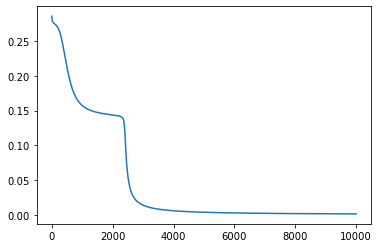

In [5]:
plt.plot(costs)

In [6]:
test = np.array([[1], [0]])
pred = 1 if Xor_net.predict(test) else 0
print("The result of the XOR b/w 1 and 0 is:", pred)

The result of the XOR b/w 1 and 0 is: 1


### Flower Problem (petal length and age --> color)

In [7]:
X_train = np.array([[3, 2, 4, 3, 3.5, 2, 5.5, 1],
                    [1.5, 1, 1.5, 1, 0.5, 0.5, 1, 1]])
y_train = np.array([1, 0, 1, 0, 1, 0, 1, 0])

Flower_net = NeuralNet('binary_logloss')
Flower_net.addLayer(1, 'sigmoid')
costs, weights = Flower_net.fit(X_train, y_train, 10000)

-----Epoch:  0 -----
Accuracy: 0.0
Cost: 0.5289009890363979
-----Epoch:  10 -----
Accuracy: 0.0
Cost: 0.4780243920875343
-----Epoch:  20 -----
Accuracy: 0.0
Cost: 0.46348576502550726
-----Epoch:  30 -----
Accuracy: 0.0
Cost: 0.4504564519476011
-----Epoch:  40 -----
Accuracy: 0.0
Cost: 0.43869954206113315
-----Epoch:  50 -----
Accuracy: 0.0
Cost: 0.42804760205567033
-----Epoch:  60 -----
Accuracy: 0.0
Cost: 0.4183568012853366
-----Epoch:  70 -----
Accuracy: 0.0
Cost: 0.4095039264833418
-----Epoch:  80 -----
Accuracy: 0.0
Cost: 0.40138358478813285
-----Epoch:  90 -----
Accuracy: 0.0
Cost: 0.393905650251693
-----Epoch:  100 -----
Accuracy: 0.0
Cost: 0.3869929991702367
-----Epoch:  110 -----
Accuracy: 0.0
Cost: 0.38057954031748636
-----Epoch:  120 -----
Accuracy: 0.0
Cost: 0.3746085245113549
-----Epoch:  130 -----
Accuracy: 0.125
Cost: 0.36903110717931603
-----Epoch:  140 -----
Accuracy: 0.125
Cost: 0.3638051335545932
-----Epoch:  150 -----
Accuracy: 0.125
Cost: 0.35889411603092425
-----Ep

-----Epoch:  1360 -----
Accuracy: 0.375
Cost: 0.2073319659515788
-----Epoch:  1370 -----
Accuracy: 0.375
Cost: 0.2069332044166622
-----Epoch:  1380 -----
Accuracy: 0.375
Cost: 0.20653858903369807
-----Epoch:  1390 -----
Accuracy: 0.375
Cost: 0.20614805280668358
-----Epoch:  1400 -----
Accuracy: 0.375
Cost: 0.20576153016842139
-----Epoch:  1410 -----
Accuracy: 0.375
Cost: 0.20537895694242217
-----Epoch:  1420 -----
Accuracy: 0.375
Cost: 0.20500027030605028
-----Epoch:  1430 -----
Accuracy: 0.375
Cost: 0.2046254087548642
-----Epoch:  1440 -----
Accuracy: 0.375
Cost: 0.20425431206810607
-----Epoch:  1450 -----
Accuracy: 0.375
Cost: 0.20388692127529306
-----Epoch:  1460 -----
Accuracy: 0.375
Cost: 0.20352317862387076
-----Epoch:  1470 -----
Accuracy: 0.375
Cost: 0.20316302754788623
-----Epoch:  1480 -----
Accuracy: 0.375
Cost: 0.20280641263764135
-----Epoch:  1490 -----
Accuracy: 0.375
Cost: 0.20245327961029158
-----Epoch:  1500 -----
Accuracy: 0.375
Cost: 0.2021035752813532
-----Epoch:  1

Accuracy: 0.625
Cost: 0.17645028578682878
-----Epoch:  2640 -----
Accuracy: 0.625
Cost: 0.17630039008592077
-----Epoch:  2650 -----
Accuracy: 0.625
Cost: 0.17615134697072407
-----Epoch:  2660 -----
Accuracy: 0.625
Cost: 0.17600314826814534
-----Epoch:  2670 -----
Accuracy: 0.625
Cost: 0.17585578591048623
-----Epoch:  2680 -----
Accuracy: 0.625
Cost: 0.17570925193375433
-----Epoch:  2690 -----
Accuracy: 0.625
Cost: 0.17556353847600842
-----Epoch:  2700 -----
Accuracy: 0.625
Cost: 0.17541863777573322
-----Epoch:  2710 -----
Accuracy: 0.625
Cost: 0.1752745421702453
-----Epoch:  2720 -----
Accuracy: 0.625
Cost: 0.17513124409412975
-----Epoch:  2730 -----
Accuracy: 0.625
Cost: 0.17498873607770551
-----Epoch:  2740 -----
Accuracy: 0.625
Cost: 0.17484701074551856
-----Epoch:  2750 -----
Accuracy: 0.625
Cost: 0.1747060608148658
-----Epoch:  2760 -----
Accuracy: 0.625
Cost: 0.17456587909434343
-----Epoch:  2770 -----
Accuracy: 0.625
Cost: 0.1744264584824241
-----Epoch:  2780 -----
Accuracy: 0.6

-----Epoch:  3970 -----
Accuracy: 0.625
Cost: 0.16171099902519934
-----Epoch:  3980 -----
Accuracy: 0.625
Cost: 0.1616294153376096
-----Epoch:  3990 -----
Accuracy: 0.625
Cost: 0.161548126205082
-----Epoch:  4000 -----
Accuracy: 0.625
Cost: 0.16146712969948956
-----Epoch:  4010 -----
Accuracy: 0.625
Cost: 0.16138642390996497
-----Epoch:  4020 -----
Accuracy: 0.625
Cost: 0.16130600694270714
-----Epoch:  4030 -----
Accuracy: 0.625
Cost: 0.16122587692078869
-----Epoch:  4040 -----
Accuracy: 0.625
Cost: 0.16114603198396668
-----Epoch:  4050 -----
Accuracy: 0.625
Cost: 0.16106647028849622
-----Epoch:  4060 -----
Accuracy: 0.625
Cost: 0.16098719000694606
-----Epoch:  4070 -----
Accuracy: 0.625
Cost: 0.16090818932801654
-----Epoch:  4080 -----
Accuracy: 0.625
Cost: 0.1608294664563606
-----Epoch:  4090 -----
Accuracy: 0.625
Cost: 0.1607510196124071
-----Epoch:  4100 -----
Accuracy: 0.625
Cost: 0.16067284703218546
-----Epoch:  4110 -----
Accuracy: 0.625
Cost: 0.1605949469671542
-----Epoch:  412

-----Epoch:  5660 -----
Accuracy: 0.625
Cost: 0.1509936286766933
-----Epoch:  5670 -----
Accuracy: 0.625
Cost: 0.15094369904855068
-----Epoch:  5680 -----
Accuracy: 0.625
Cost: 0.1508938858038497
-----Epoch:  5690 -----
Accuracy: 0.625
Cost: 0.15084418840567487
-----Epoch:  5700 -----
Accuracy: 0.625
Cost: 0.15079460632053676
-----Epoch:  5710 -----
Accuracy: 0.625
Cost: 0.1507451390183446
-----Epoch:  5720 -----
Accuracy: 0.625
Cost: 0.15069578597237882
-----Epoch:  5730 -----
Accuracy: 0.625
Cost: 0.15064654665926336
-----Epoch:  5740 -----
Accuracy: 0.625
Cost: 0.15059742055893952
-----Epoch:  5750 -----
Accuracy: 0.625
Cost: 0.15054840715463902
-----Epoch:  5760 -----
Accuracy: 0.625
Cost: 0.15049950593285705
-----Epoch:  5770 -----
Accuracy: 0.625
Cost: 0.15045071638332727
-----Epoch:  5780 -----
Accuracy: 0.625
Cost: 0.15040203799899476
-----Epoch:  5790 -----
Accuracy: 0.625
Cost: 0.15035347027599108
-----Epoch:  5800 -----
Accuracy: 0.625
Cost: 0.15030501271360858
-----Epoch:  

-----Epoch:  7420 -----
Accuracy: 0.625
Cost: 0.14362229789673883
-----Epoch:  7430 -----
Accuracy: 0.625
Cost: 0.14358684384522227
-----Epoch:  7440 -----
Accuracy: 0.625
Cost: 0.1435514471615391
-----Epoch:  7450 -----
Accuracy: 0.625
Cost: 0.14351610764495146
-----Epoch:  7460 -----
Accuracy: 0.625
Cost: 0.14348082509570148
-----Epoch:  7470 -----
Accuracy: 0.625
Cost: 0.14344559931500675
-----Epoch:  7480 -----
Accuracy: 0.625
Cost: 0.1434104301050538
-----Epoch:  7490 -----
Accuracy: 0.625
Cost: 0.14337531726899205
-----Epoch:  7500 -----
Accuracy: 0.625
Cost: 0.1433402606109275
-----Epoch:  7510 -----
Accuracy: 0.625
Cost: 0.14330525993591775
-----Epoch:  7520 -----
Accuracy: 0.625
Cost: 0.14327031504996496
-----Epoch:  7530 -----
Accuracy: 0.625
Cost: 0.143235425760011
-----Epoch:  7540 -----
Accuracy: 0.625
Cost: 0.14320059187393094
-----Epoch:  7550 -----
Accuracy: 0.625
Cost: 0.14316581320052787
-----Epoch:  7560 -----
Accuracy: 0.625
Cost: 0.1431310895495269
-----Epoch:  757

-----Epoch:  9120 -----
Accuracy: 0.625
Cost: 0.13828502988735367
-----Epoch:  9130 -----
Accuracy: 0.625
Cost: 0.13825707024924758
-----Epoch:  9140 -----
Accuracy: 0.625
Cost: 0.13822914422864915
-----Epoch:  9150 -----
Accuracy: 0.625
Cost: 0.13820125173077416
-----Epoch:  9160 -----
Accuracy: 0.625
Cost: 0.1381733926612154
-----Epoch:  9170 -----
Accuracy: 0.625
Cost: 0.1381455669259402
-----Epoch:  9180 -----
Accuracy: 0.625
Cost: 0.13811777443128967
-----Epoch:  9190 -----
Accuracy: 0.625
Cost: 0.13809001508397598
-----Epoch:  9200 -----
Accuracy: 0.625
Cost: 0.13806228879108068
-----Epoch:  9210 -----
Accuracy: 0.625
Cost: 0.13803459546005278
-----Epoch:  9220 -----
Accuracy: 0.625
Cost: 0.1380069349987073
-----Epoch:  9230 -----
Accuracy: 0.625
Cost: 0.1379793073152229
-----Epoch:  9240 -----
Accuracy: 0.625
Cost: 0.13795171231814046
-----Epoch:  9250 -----
Accuracy: 0.625
Cost: 0.13792414991636068
-----Epoch:  9260 -----
Accuracy: 0.625
Cost: 0.13789662001914313
-----Epoch:  9

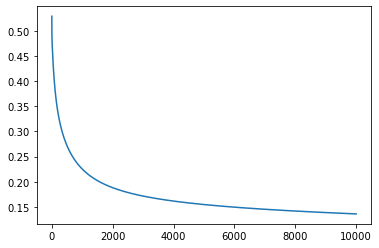

In [8]:
plt.plot(costs)

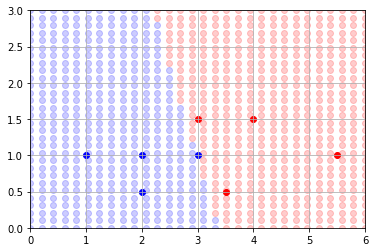

In [9]:
#Visualizing Flower problem

def vis_data():
    plt.axis([0, 6, 0 ,3])
    plt.grid()
    for i in range(X_train.shape[1]):
        point  = X_train[:, i]
        color = 'r'
        if y_train[i] == 0:
            color = 'b'
        plt.scatter(point[0], point[1], c=color)
    
# check out the networks predictions in the x,y plane
for x in np.linspace(0, 6, 30):
    for y in np.linspace(0, 3, 30):
        test = np.array([[x],[y]])
        pred = Flower_net.predict(test)
        c = 'b'
        if pred > .5:
            c = 'r'
        plt.scatter([x],[y],c=c, alpha=.2)

vis_data()

### MNIST Dataset --> Recognizing Handwritten digits

The MNIST dataset is trained on the neural network in 4 different ways.
- Without batches and with only a single hidden layer
- With batches and with only a single hidden layer
- Without batches and with multiple hidden layers
- With batches and with multiple hdden layers
The last 'test_mnist_net' is there to show the ability to use the weights of a pre trained network into another of matching architecture.

Additional configuration can also take place including changing around the activation functions, num of layers, num of neurons per layer, learning rate and batches (I expect many bugs to arise from this).

In [10]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

In [253]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])

X = X[permutation]
y = y[permutation].astype(np.int)
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=60000, test_size=10000)

##scaler = StandardScaler()
X_train = X_train.T
X_test = X_test.T
X_train = X_train/255
X_test = X_test/255

In [279]:
outfile = open('test_images', 'wb')
pickle.dump(X_test, outfile)
outfile.close()

outfile = open('test_labels', 'wb')
pickle.dump(y_test, outfile)
outfile.close()

In [12]:
def get_test_accuracy(net):
    y_pred = net.predict(X_test)
    test_accuracy = 100*np.sum(y_test == np.argmax(y_pred, 0), axis=0) / X_test.shape[1]
    print(test_accuracy)

### MNIST Dataset With 1 Hidden Layer + No Batches

In [13]:
mnist_net = NeuralNet('multi_logloss')
mnist_net.addLayer(64, 'reLu')
mnist_net.addLayer(10, 'softmax')
costs, mnist_weights = mnist_net.fit(X_train, y_train, 2000, 60000)

-----Epoch:  0 -----
Accuracy: 0.05366666666666667
Cost: 2.466751337389721
-----Epoch:  10 -----
Accuracy: 0.5485833333333333
Cost: 1.1847559238008232
-----Epoch:  20 -----
Accuracy: 0.6806333333333333
Cost: 1.0634580287879696
-----Epoch:  30 -----
Accuracy: 0.7345166666666667
Cost: 1.01875193701685
-----Epoch:  40 -----
Accuracy: 0.7653333333333333
Cost: 0.9945794771551656
-----Epoch:  50 -----
Accuracy: 0.7847333333333333
Cost: 0.9789735521116122
-----Epoch:  60 -----
Accuracy: 0.7982333333333334
Cost: 0.9678508900275774
-----Epoch:  70 -----
Accuracy: 0.8084833333333333
Cost: 0.9594198001384417
-----Epoch:  80 -----
Accuracy: 0.8174333333333333
Cost: 0.952721881550396
-----Epoch:  90 -----
Accuracy: 0.8249166666666666
Cost: 0.9472703462011776
-----Epoch:  100 -----
Accuracy: 0.8311666666666667
Cost: 0.9427519321851021
-----Epoch:  110 -----
Accuracy: 0.8369
Cost: 0.9389668832966809
-----Epoch:  120 -----
Accuracy: 0.8417666666666667
Cost: 0.9357393265870206
-----Epoch:  130 -----
Ac

-----Epoch:  1120 -----
Accuracy: 0.9211166666666667
Cost: 0.8969950933757889
-----Epoch:  1130 -----
Accuracy: 0.9213833333333333
Cost: 0.8969059696043845
-----Epoch:  1140 -----
Accuracy: 0.9216166666666666
Cost: 0.8968178192898236
-----Epoch:  1150 -----
Accuracy: 0.9219
Cost: 0.8967305909876926
-----Epoch:  1160 -----
Accuracy: 0.92215
Cost: 0.8966442188457926
-----Epoch:  1170 -----
Accuracy: 0.9224666666666667
Cost: 0.8965587502233902
-----Epoch:  1180 -----
Accuracy: 0.9226166666666666
Cost: 0.8964741619479671
-----Epoch:  1190 -----
Accuracy: 0.9229166666666667
Cost: 0.8963904228775983
-----Epoch:  1200 -----
Accuracy: 0.92315
Cost: 0.8963075975413127
-----Epoch:  1210 -----
Accuracy: 0.9233
Cost: 0.8962256434704728
-----Epoch:  1220 -----
Accuracy: 0.9235333333333333
Cost: 0.8961445165489202
-----Epoch:  1230 -----
Accuracy: 0.9237333333333333
Cost: 0.8960641535189456
-----Epoch:  1240 -----
Accuracy: 0.9239833333333334
Cost: 0.8959845692014519
-----Epoch:  1250 -----
Accuracy

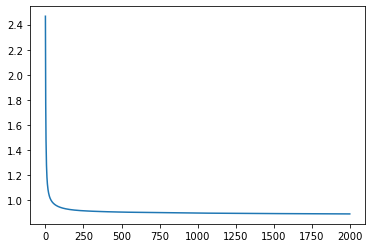

In [14]:
plt.plot(costs)

In [15]:
get_test_accuracy(mnist_net)

92.44


### MNIST Dataset With 1 Hidden Layer + Batches (size 500)

In [16]:
mnist_net_batches = NeuralNet('multi_logloss')
mnist_net_batches.addLayer(64, 'reLu')
mnist_net_batches.addLayer(10, 'softmax')
costs_batches, weights_batches = mnist_net_batches.fit(X_train, y_train, 1000, 500)

-----Epoch:  0 -----
Accuracy: 0.082
Cost: 1.8670070512182189
-----Epoch:  10 -----
Accuracy: 0.914
Cost: 0.4131290202732777
-----Epoch:  20 -----
Accuracy: 0.95
Cost: 0.4071646881766138
-----Epoch:  30 -----
Accuracy: 0.964
Cost: 0.4038190533468727
-----Epoch:  40 -----
Accuracy: 0.972
Cost: 0.4017133983554123
-----Epoch:  50 -----
Accuracy: 0.976
Cost: 0.4002542345086098
-----Epoch:  60 -----
Accuracy: 0.978
Cost: 0.39914979751896873
-----Epoch:  70 -----
Accuracy: 0.984
Cost: 0.39823904259612075
-----Epoch:  80 -----
Accuracy: 0.984
Cost: 0.39747688331145065
-----Epoch:  90 -----
Accuracy: 0.984
Cost: 0.3968398622594358
-----Epoch:  100 -----
Accuracy: 0.984
Cost: 0.3963591773502795
-----Epoch:  110 -----
Accuracy: 0.988
Cost: 0.39592973532992265
-----Epoch:  120 -----
Accuracy: 0.988
Cost: 0.39552235627921084
-----Epoch:  130 -----
Accuracy: 0.988
Cost: 0.39516122783506447
-----Epoch:  140 -----
Accuracy: 0.99
Cost: 0.394804468355694
-----Epoch:  150 -----
Accuracy: 0.99
Cost: 0.39

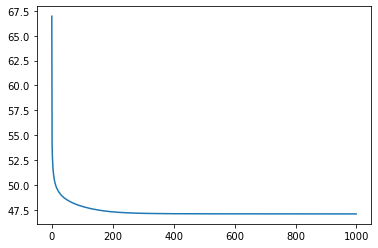

In [17]:
plt.plot(costs_batches)

In [18]:
get_test_accuracy(mnist_net_batches)

95.58


<ipython-input-2-7fa85942c107>:22: RuntimeWarning: overflow encountered in exp
  return np.exp(Z) / sum(np.exp(Z))
<ipython-input-2-7fa85942c107>:22: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(Z) / sum(np.exp(Z))


### MNIST Dataset With 2 Hidden Layer + Batches (size 1000)

In [272]:
mnist_net_multipHidden_batches = NeuralNet('multi_logloss')
mnist_net_multipHidden_batches.addLayer(64, 'reLu')
mnist_net_multipHidden_batches.addLayer(64, 'reLu')
mnist_net_multipHidden_batches.addLayer(10, 'softmax')
costs, weights_multipHidden_batches, biases_multipHidden_batches = mnist_net_multipHidden_batches.fit(X_train, y_train, 600, 1000)

-----Epoch:  0 -----
Accuracy: 0.749
Cost: 36.50090538517477
-----Epoch:  10 -----
Accuracy: 0.909
Cost: 29.36260137950539
-----Epoch:  20 -----
Accuracy: 0.931
Cost: 28.92827721686502
-----Epoch:  30 -----
Accuracy: 0.94
Cost: 28.709133524366177
-----Epoch:  40 -----
Accuracy: 0.948
Cost: 28.56709930260407
-----Epoch:  50 -----
Accuracy: 0.954
Cost: 28.464824137842985
-----Epoch:  60 -----
Accuracy: 0.957
Cost: 28.385518839057248
-----Epoch:  70 -----
Accuracy: 0.958
Cost: 28.322134521137485
-----Epoch:  80 -----
Accuracy: 0.963
Cost: 28.26968917832101
-----Epoch:  90 -----
Accuracy: 0.966
Cost: 28.224806580132867
-----Epoch:  100 -----
Accuracy: 0.968
Cost: 28.18599912506319
-----Epoch:  110 -----
Accuracy: 0.969
Cost: 28.15139089007836
-----Epoch:  120 -----
Accuracy: 0.972
Cost: 28.120420267194202
-----Epoch:  130 -----
Accuracy: 0.972
Cost: 28.09211268468257
-----Epoch:  140 -----
Accuracy: 0.971
Cost: 28.06592607837998
-----Epoch:  150 -----
Accuracy: 0.972
Cost: 28.0417019031457

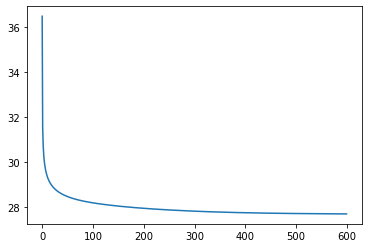

In [273]:
plt.plot(costs)

In [274]:
get_test_accuracy(mnist_net_multipHidden_batches)

96.28


### MNIST Dataset With 2 Hidden Layer + No Batches

This one takes forever

In [41]:
mnist_net_multipHidden = NeuralNet('multi_logloss')
mnist_net_multipHidden.addLayer(64, 'reLu')
mnist_net_multipHidden.addLayer(64, 'reLu')
mnist_net_multipHidden.addLayer(10, 'softmax')
costs, weights_multipHidden = mnist_net_multipHidden.fit(X_train, y_train, 2000, 60000)

-----Epoch:  0 -----
Accuracy: 0.0841
Cost: 2.8222368903670825
-----Epoch:  10 -----
Accuracy: 0.5922166666666666
Cost: 1.1273622771816205
-----Epoch:  20 -----
Accuracy: 0.6584666666666666
Cost: 1.043132122107689
-----Epoch:  30 -----
Accuracy: 0.6947666666666666
Cost: 1.0067442745550457
-----Epoch:  40 -----
Accuracy: 0.7184333333333334
Cost: 0.9863990696782855
-----Epoch:  50 -----
Accuracy: 0.73615
Cost: 0.973303536713376
-----Epoch:  60 -----
Accuracy: 0.75145
Cost: 0.9641254855392057
-----Epoch:  70 -----
Accuracy: 0.7639666666666667
Cost: 0.9572808897760625
-----Epoch:  80 -----
Accuracy: 0.77415
Cost: 0.9518831416965255
-----Epoch:  90 -----
Accuracy: 0.78455
Cost: 0.9474808204216365
-----Epoch:  100 -----
Accuracy: 0.7933666666666667
Cost: 0.9437837393486436
-----Epoch:  110 -----
Accuracy: 0.8008833333333333
Cost: 0.94062947604732
-----Epoch:  120 -----
Accuracy: 0.8022666666666667
Cost: 0.9390361356779319
-----Epoch:  130 -----
Accuracy: 0.8104166666666667
Cost: 0.9363409145

-----Epoch:  1110 -----
Accuracy: 0.9277666666666666
Cost: 0.8935845816554815
-----Epoch:  1120 -----
Accuracy: 0.92815
Cost: 0.8934722956699694
-----Epoch:  1130 -----
Accuracy: 0.9286666666666666
Cost: 0.8933609697358796
-----Epoch:  1140 -----
Accuracy: 0.9289666666666667
Cost: 0.8932510212333156
-----Epoch:  1150 -----
Accuracy: 0.9295166666666667
Cost: 0.8931421610554877
-----Epoch:  1160 -----
Accuracy: 0.9297
Cost: 0.8930348704627118
-----Epoch:  1170 -----
Accuracy: 0.9299
Cost: 0.8929289814127997
-----Epoch:  1180 -----
Accuracy: 0.9301333333333334
Cost: 0.8928243546137911
-----Epoch:  1190 -----
Accuracy: 0.9304
Cost: 0.8927208862594936
-----Epoch:  1200 -----
Accuracy: 0.9304833333333333
Cost: 0.8926187489329185
-----Epoch:  1210 -----
Accuracy: 0.93075
Cost: 0.8925179863169524
-----Epoch:  1220 -----
Accuracy: 0.9309
Cost: 0.8924184896672595
-----Epoch:  1230 -----
Accuracy: 0.9313
Cost: 0.8923199332012443
-----Epoch:  1240 -----
Accuracy: 0.9315666666666667
Cost: 0.8922222

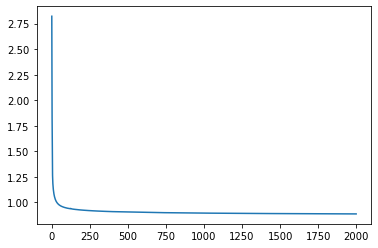

In [42]:
plt.plot(costs)

In [43]:
get_test_accuracy(mnist_net_multipHidden)

92.51


<ipython-input-2-7fa85942c107>:22: RuntimeWarning: overflow encountered in exp
  return np.exp(Z) / sum(np.exp(Z))
<ipython-input-2-7fa85942c107>:22: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(Z) / sum(np.exp(Z))


### Testing Ability to use Previously Determined Weights

In [275]:
test_mnist_net = NeuralNet('multi_logloss')
test_mnist_net.addLayer(64, 'reLu')
test_mnist_net.addLayer(64, 'reLu')
test_mnist_net.addLayer(10, 'softmax')
test_mnist_net.set_weights(weights_multipHidden_batches)
test_mnist_net.set_biases(biases_multipHidden_batches)

In [276]:
get_test_accuracy(test_mnist_net)

96.28


In [278]:
outfile = open('mnist_weights_final', 'wb')
pickle.dump(weights_multipHidden_batches, outfile)
outfile.close()

outfile = open('mnist_biases_final', 'wb')
pickle.dump(biases_multipHidden_batches, outfile)
outfile.close()

### Training on MNIST data from official website to see if it makes a difference

In [139]:
import struct

In [150]:
def load_data():
    with open('mnist-classifier-neuralnet/train-labels-idx1-ubyte', 'rb') as labels:
        magic, n = struct.unpack('>II', labels.read(8)) ##reading 8 bytes, first 2 lines
        train_labels = np.fromfile(labels, dtype=np.uint8)
    with open('mnist-classifier-neuralnet/train-images-idx3-ubyte', 'rb') as images:
        magic, num, nrows, ncols = struct.unpack(">IIII", images.read(16)) ##reading 16 bytes, first 4 lines
        train_images = np.fromfile(images, dtype=np.uint8).reshape(num, 784) ##reshaping image as 784 row vecotr (28x28 px)
    with open('mnist-classifier-neuralnet/t10k-labels-idx1-ubyte', 'rb') as labels:
        magic, n = struct.unpack('>II', labels.read(8)) ##reading 8 bytes, first 2 lines
        test_labels = np.fromfile(labels, dtype=np.uint8)
    with open('mnist-classifier-neuralnet/t10k-images-idx3-ubyte', 'rb') as images:
        magic, num, nrows, ncols = struct.unpack(">IIII", images.read(16)) ##reading 16 bytes, first 4 lines
        test_images = np.fromfile(images, dtype=np.uint8).reshape(num, 784) ##reshaping image as 784 row vecotr (28x28 px)
    return train_images, train_labels, test_images, test_labels   

In [188]:
train_images, train_labels, test_images, test_labels  = load_data()
test_images = test_images.T
train_images = train_images.T
test_images = test_images/255
train_images = train_images/255
# scaler2  = StandardScaler()
# train_images = scaler2.fit_transform(train_images).T
# test_images = scaler2.transform(test_images).T

In [189]:
def get_test_accuracy2(net):
    y_pred = net.predict(test_images)
    test_accuracy = 100*np.sum(test_labels == np.argmax(y_pred, 0), axis=0) / test_images.shape[1]
    print(test_accuracy)

In [192]:
mnist_net_multipHidden_batches_newData = NeuralNet('multi_logloss')
mnist_net_multipHidden_batches_newData.addLayer(64, 'reLu')
mnist_net_multipHidden_batches_newData.addLayer(10, 'softmax')
costs, weights_multipHidden_batches_newData = mnist_net_multipHidden_batches_newData.fit(train_images, train_labels, 500, 1000)

-----Epoch:  0 -----
Accuracy: 0.785
Cost: 37.00871142178752
-----Epoch:  10 -----
Accuracy: 0.934
Cost: 29.724266791134976
-----Epoch:  20 -----
Accuracy: 0.95
Cost: 29.287382399917444
-----Epoch:  30 -----
Accuracy: 0.959
Cost: 29.05274000529904
-----Epoch:  40 -----
Accuracy: 0.962
Cost: 28.896692253012873
-----Epoch:  50 -----
Accuracy: 0.969
Cost: 28.78221540043466
-----Epoch:  60 -----
Accuracy: 0.969
Cost: 28.69179658965031
-----Epoch:  70 -----
Accuracy: 0.97
Cost: 28.61722777700944
-----Epoch:  80 -----
Accuracy: 0.972
Cost: 28.554118886981982
-----Epoch:  90 -----
Accuracy: 0.972
Cost: 28.49982920021886
-----Epoch:  100 -----
Accuracy: 0.974
Cost: 28.45248950285321
-----Epoch:  110 -----
Accuracy: 0.974
Cost: 28.41078086249382
-----Epoch:  120 -----
Accuracy: 0.974
Cost: 28.373497318648155
-----Epoch:  130 -----
Accuracy: 0.974
Cost: 28.339618246167998
-----Epoch:  140 -----
Accuracy: 0.976
Cost: 28.308376592970852
-----Epoch:  150 -----
Accuracy: 0.978
Cost: 28.2797362444667

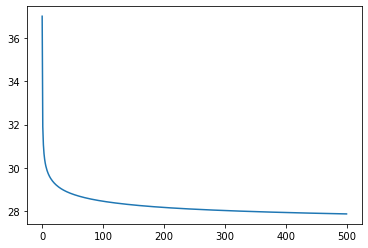

In [193]:
plt.plot(costs)

In [194]:
get_test_accuracy2(mnist_net_multipHidden_batches_newData)

96.76


### TEST A RANDOM NUMBER FROM THE TEST SET --> img_inde is 0 - 9999

In [220]:
def test(img_index, net):
    plt.imshow(test_images[:, img_index].reshape(28, 28), cmap='Greys', interpolation='nearest')
    print(np.argmax(net.predict(test_images[:, img_index].reshape(784, 1)), 0)[0])

9


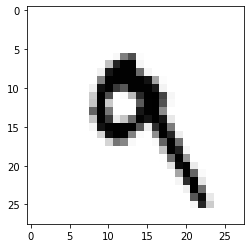

In [248]:
test(7, testnet)

In [239]:
infile = open('random_img', 'rb')
test_img = pickle.load(infile)
infile.close()
test_img = test_img.reshape(784, 1)

3


array([[2.72341712e-07],
       [1.94872168e-01],
       [2.54085277e-01],
       [3.33810203e-01],
       [1.08942722e-06],
       [7.67153528e-09],
       [6.00801691e-12],
       [2.16578060e-01],
       [6.36958749e-04],
       [1.59630547e-05]])

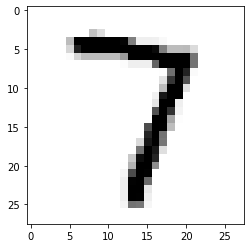

In [249]:
plt.imshow(test_img.reshape(28, 28), cmap='Greys', interpolation='nearest')
print(np.argmax(testnet.predict(test_img)))
testnet.predict(test_img)

In [200]:
def visualize_data(img_array, label_array):
    fig, ax = plt.subplots(nrows=8, ncols=8, sharex=True, sharey=True)
    ax = ax.flatten()
    count = -1
    for i, num in enumerate(label_array):
        if num == 9 and count < 63:
            count+=1
            img = img_array[:, i].reshape(28, 28)
            ax[count].imshow(img, cmap='Greys', interpolation='nearest')
    plt.show()
def visualize_data2(img_array, label_array):
    fig, ax = plt.subplots(nrows=8, ncols=8, sharex=True, sharey=True)
    ax = ax.flatten()
    for i in range(64):
        img = img_array[label_array == 9][i].reshape(28, 28)
        ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    plt.show()

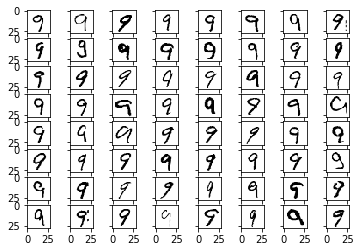

In [254]:
visualize_data(X_test, y_test)

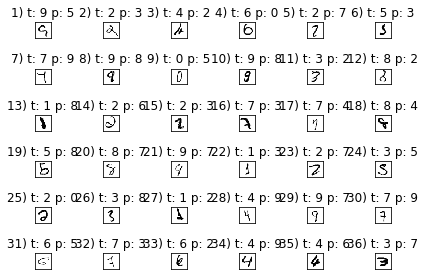

5

In [214]:
y_pred = np.argmax(mnist_net_multipHidden_batches_newData.predict(test_images), 0)
misclassified_img = test_images[:, test_labels != y_pred][:, :36]
correct_label = test_labels[test_labels != y_pred][:36]
misclassified_label = y_pred[test_labels != y_pred][:36]
count = np.sum(correct_label == 9)
fig, ax = plt.subplots(6, 6, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(36):
    img = misclassified_img[:, i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i + 1, correct_label[i], misclassified_label[i]))
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()
count

### Dumping the contents of the weights_batches into a file to be of use later

In [100]:
280*280*4

313600

In [50]:
import pickle

In [243]:
outfile = open('test_labels','wb')

In [244]:
pickle.dump(test_labels,outfile)
outfile.close()

In [91]:
outfile_scaler = open('scaler', 'wb')
pickle.dump(scaler, outfile_scaler)
outfile_scaler.close()

In [247]:
testnet = NeuralNet('multi_logloss')
testnet.addLayer(64, 'reLu')
testnet.addLayer(10, 'softmax')
testnet.set_weights(weights_multipHidden_batches_newData)
get_test_accuracy2(testnet)

95.95
